In [1]:
!pwd

/home/toleg/vanya/repo/notebooks


In [2]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

from osgeo import gdal_array

In [3]:
path = '../data/geo/'
arr = gdal_array.LoadFile(path + 'geobin.tif')
h,w = arr.shape
ratio = w/h
iw = 14
ih = iw/ratio
(ratio, iw, ih)

(1.1092077087794432, 14, 12.621621621621623)

In [4]:
img = cv.normalize(src=arr, dst=None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_8UC1)

In [5]:
(img.min(), img.max(), type(img[1,1]))

(0, 255, numpy.uint8)

In [6]:
def show_image(arr, title='Title'):
    fig = plt.figure(figsize=(iw,ih))
    plt.title(title)
    plt.imshow(arr, cmap='gray')

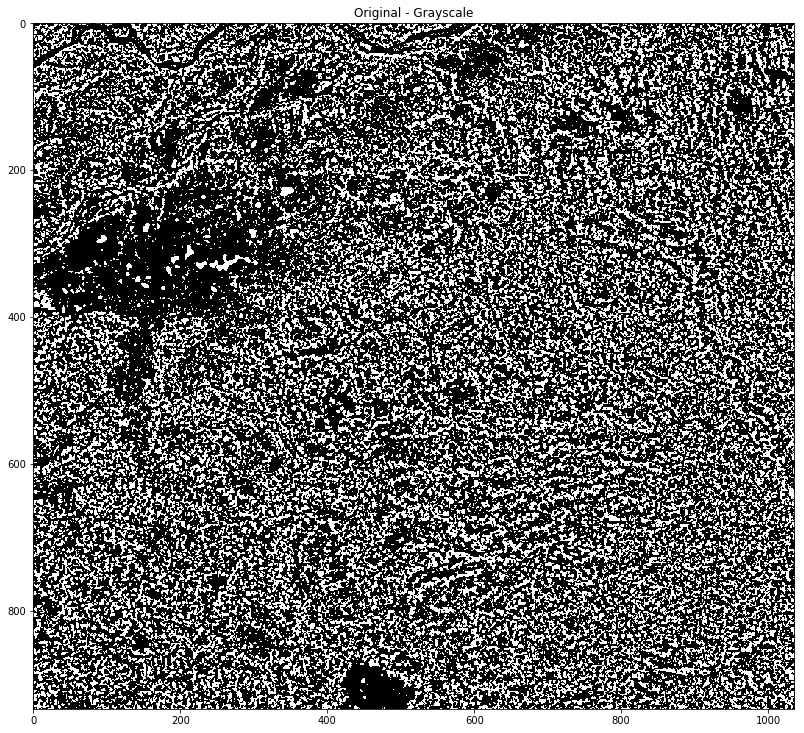

In [7]:
show_image(img, 'Original - Grayscale')

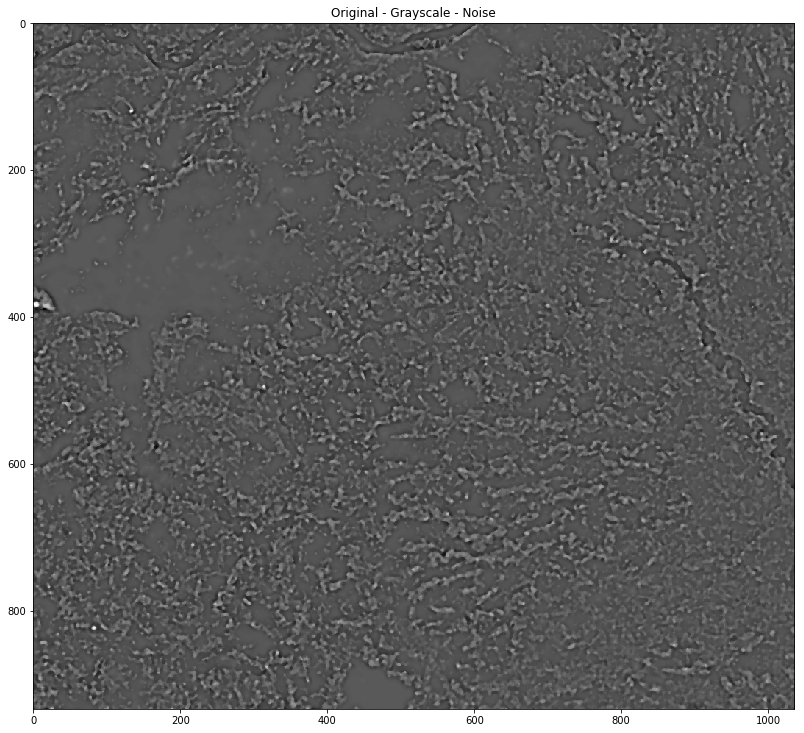

In [8]:
img_noise = cv.medianBlur(img, 5)
show_image(img_noise, 'Original - Grayscale - Noise')

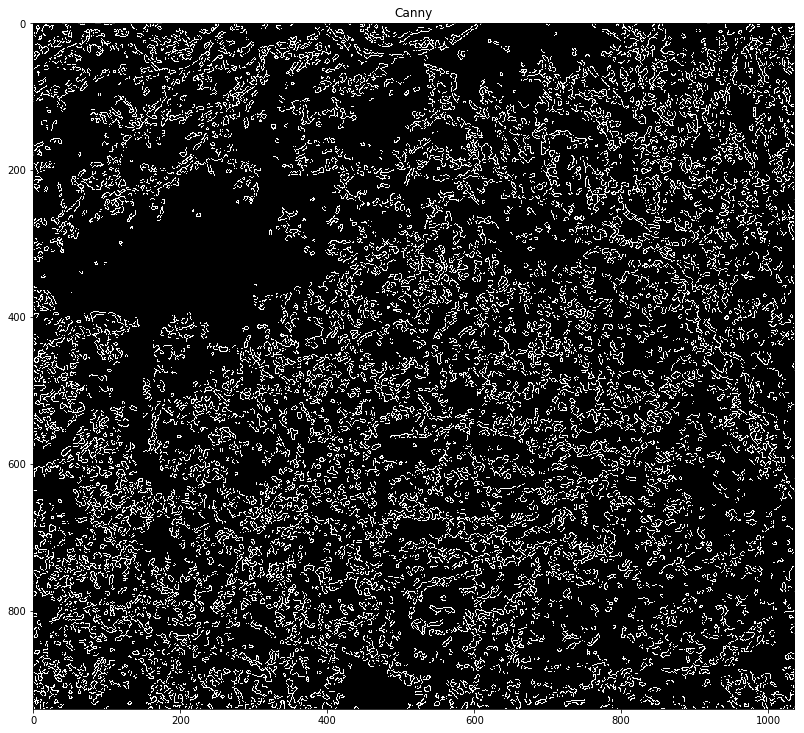

In [10]:
img_canny = cv.Canny(img_noise, 40, 80)

show_image(img_canny, 'Canny')

In [9]:
def calc_prob(arr):
    cnt = len(arr);
    col = np.empty((cnt, 1), np.float64)
    
    #print(col.shape)
    #print(arr.shape)
    
    arr = np.hstack((arr, col))
    
    step = 1/cnt;
    for i in range(cnt):
        #arr = np.float64(np.around(arr))     # such format changes array datatype
        arr[i][0] = round(arr[i][0])
        arr[i][1] = round(arr[i][1])
        arr[i][2] = round(arr[i][2])
        
        arr[i][3] = round(1 - i*step, 6) 
        
    return arr

calc_prob([[1.4, 2.7, 3.2], [5.6, 7.7, 8.1], [1.1, 2.2, 3.3]])

array([[1.      , 3.      , 3.      , 1.      ],
       [6.      , 8.      , 8.      , 0.666667],
       [1.      , 2.      , 3.      , 0.333333]])

In [10]:
rows = h
acc_img_inv_ratio=1.7
canny_high_threshold=80
acc_threshold=4
max_radius = 100

circles = np.empty((0, 4), np.float64)

for i in range(max_radius):
    radius = i+1
    #print(radius)
    res = cv.HoughCircles(image=img, method=cv.HOUGH_GRADIENT, dp=acc_img_inv_ratio, minDist=1,
                          param1=canny_high_threshold, param2=acc_threshold,
                          minRadius=radius, maxRadius=radius)
    res = calc_prob(res[0])
    circles = np.vstack((circles, res))

In [11]:
circles.shape

(4560932, 4)

In [14]:
(circles[0:3], circles[2371953:2371955])
#(min(circles[:,2]), max(circles[:,2]))

(array([[643.      , 258.      ,   2.      ,   1.      ],
        [739.      , 266.      ,   2.      ,   0.999944],
        [162.      , 766.      ,   2.      ,   0.999889]]),
 array([[1.033e+03, 8.980e+02, 1.010e+02, 9.200e-05],
        [1.024e+03, 9.240e+02, 1.010e+02, 4.600e-05]]))

In [12]:
if circles is not None:
    #circles = np.uint16(np.around(circles))
    np.savetxt(path + 'opencv_geobin_100.csv', circles, delimiter=',', fmt='%d,%d,%d,%.6f', header='x,y,z,prob')

In [104]:
tgt = np.copy(img)

if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles[:]:
        if i[2] > 10:
            center = (i[0], i[1])
            # circle center
            cv.circle(tgt, center, 1, (0, 100, 100))
            # circle outline
            radius = i[2]
            cv.circle(tgt, center, radius, (255, 0, 255))

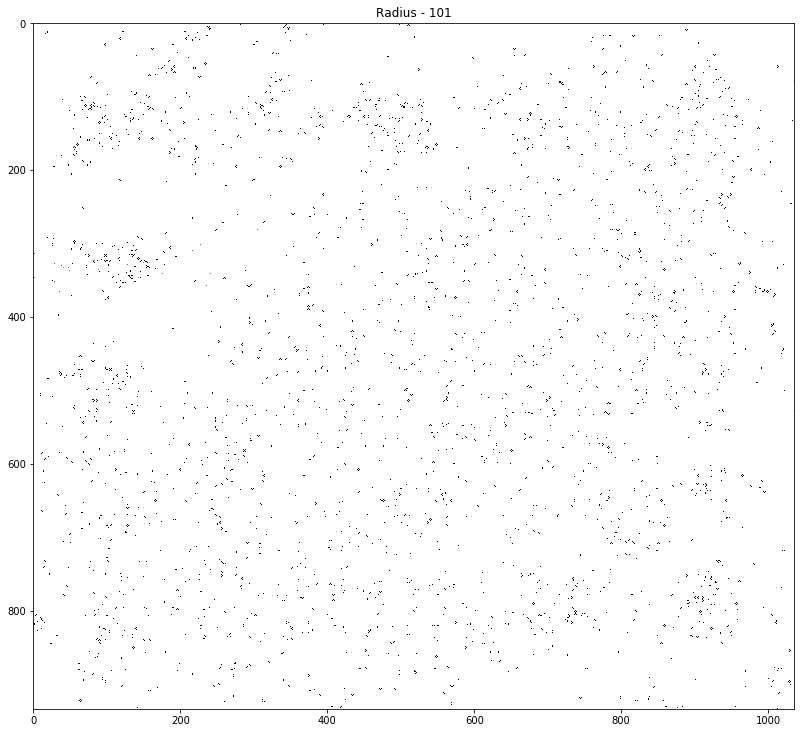

In [105]:
show_image(tgt, 'Radius - ' + str(radius))

In [121]:
circles.shape

(1, 10, 3)